## Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error
import os

Прочитаем базу my_PJME_MW.csv и сделаем ее перерасчет (ресемплинг) в представление по неделям.

In [346]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [347]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 to 2018-08-03
Data columns (total 13 columns):
Time               145374 non-null object
PJME_MW            145374 non-null float64
year               145374 non-null int64
month              145374 non-null int64
dayofmonth         145374 non-null int64
quarter            145374 non-null int64
dayofyear          145374 non-null int64
weekofyear         145374 non-null int64
dayofweek          145374 non-null int64
hour               145374 non-null int64
is_holiday         145374 non-null int64
is_prev_holiday    145374 non-null int64
is_next_holiday    145374 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 15.5+ MB


In [348]:
data_w = data.copy().resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [349]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 12 columns):
PJME_MW            866 non-null float64
year               866 non-null float64
month              866 non-null float64
dayofmonth         866 non-null float64
quarter            866 non-null float64
dayofyear          866 non-null float64
weekofyear         866 non-null float64
dayofweek          866 non-null float64
hour               866 non-null float64
is_holiday         866 non-null float64
is_prev_holiday    866 non-null float64
is_next_holiday    866 non-null float64
dtypes: float64(12)
memory usage: 88.0 KB


### Генерация признаков

Добавим признак того, что в неделе был праздник

In [350]:
data_w.loc[(data_w['is_holiday'] > 0), 'haveHoliday'] = 1

In [351]:
data_w.loc[(data_w['is_holiday'] == 0), 'haveHoliday'] = 0

Удалим данные о часах,днях в неделях, праздниках, день в месяцах, в году, т.к. они потеряли актуальность

In [352]:
data_w.drop('hour', axis=1,inplace=True)
data_w.drop('dayofweek', axis=1,inplace=True)
data_w.drop('is_holiday', axis=1,inplace=True)
data_w.drop('is_prev_holiday', axis=1,inplace=True)
data_w.drop('is_next_holiday', axis=1,inplace=True)
data_w.drop('dayofyear', axis=1,inplace=True)
data_w.drop('dayofmonth', axis=1,inplace=True)
data_w.head()

,PJME_MW,year,month,quarter,weekofyear,haveHoliday
Date,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0,1.0
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0,0.0
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0,0.0
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0,1.0
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0,0.0


Поскольку в годовом развороте ряда тренда нет (временные ряды 2 и 3), то признак 'year' можно исключить.

In [353]:
data_w.drop('year', axis=1,inplace=True)

Построим интегральный признак используя кластер-анализ или частичную классификацию.

In [354]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns

In [355]:
scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_w.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

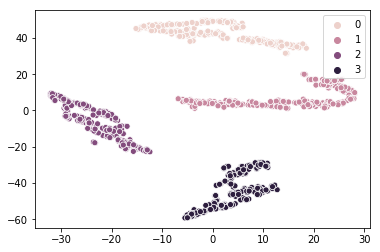

In [356]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

In [357]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  1
Число кластеров в календаре:  4


In [358]:
data_w['week_month'] = X_clast
data_w.iloc[np.where(data_w['week_month']==0)[0]].iloc[:4,:]

,PJME_MW,month,quarter,weekofyear,haveHoliday,week_month
Date,,,,,,
2002-01-06,32392.160839,1.0,1.0,1.0,1.0,0
2002-01-13,31487.386905,1.0,1.0,2.0,0.0,0
2002-01-20,31452.880952,1.0,1.0,3.0,0.0,0
2002-01-27,30141.529762,1.0,1.0,4.0,1.0,0


Получим новые признаки путем применение преобразований для понижения размерности.

In [359]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [360]:
data_w['pca1']=Xpca[:,0]
data_w['pca2']=Xpca[:,1]

Добавим новых признаков, описывающих содержание ряда.

In [361]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

In [362]:
first_diff_w =(first_diff) / data_w.iloc[1:,0].values
data_w['diff1_w'] = 0
data_w['diff1_w'] =  data_w['diff1_w'].astype('float') 
data_w['diff1_w'].values[1:] = np.array(first_diff_w).astype('float32')

In [363]:
first_diff_l =np.log(data_w.iloc[1:,0].values) 
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l

Добавим скользящее среднее по всей модели с глубиной 13 недель. Сезонность по предыдущей лекции составляет 3, 6, 12 месяцев возьмем полгода.

In [364]:
data_w['d_m13']=data_w['PJME_MW'].rolling(window=13).mean()

Теперь добавим экспонентциальную среднюю.

In [365]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)

In [366]:
data_w.iloc[10:15,:]

,PJME_MW,month,quarter,weekofyear,haveHoliday,week_month,pca1,pca2,diff1,diff1_w,diff1_l,d_m13,exp_0_05
Date,,,,,,,,,,,,,
2002-03-17,28672.779762,3.0,1.0,11.0,0.0,0,-1.950090,0.271175,-768.130981,-0.026790,10.263704,NaN,31436.852496
2002-03-24,29927.488095,3.0,1.0,12.0,0.0,0,-1.911640,0.308858,1254.708374,0.041925,10.306533,NaN,31361.384276
2002-03-31,27595.869048,3.0,1.0,13.0,0.0,0,-1.873191,0.346540,-2331.619141,-0.084492,10.225421,30083.670797,31173.108514
2002-04-07,28308.778443,4.0,2.0,14.0,0.0,1,-1.139586,-0.272991,712.909424,0.025183,10.250927,29769.564459,31029.892011
2002-04-14,27182.482143,4.0,2.0,15.0,0.0,1,-1.101137,-0.235309,-1126.296265,-0.041435,10.210328,29438.417939,30837.521517


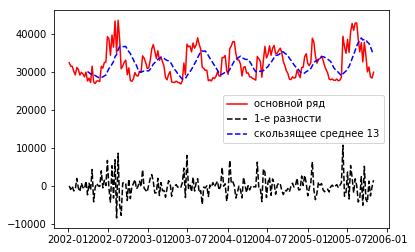

In [367]:
N100=200
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_w.index[:N100],data_w['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_w.index[:N100],data_w['d_m13'][:N100],'--b',label ='скользящее среднее 13')
plt.legend()
plt.show()

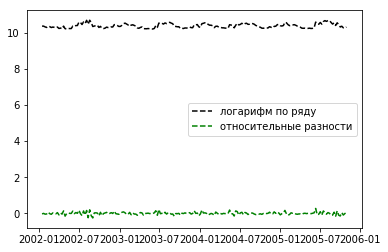

In [368]:
N100=200
plt.plot(data_w.index[1:N100],data_w['diff1_l'][1:N100],'--k',label ='логарифм по ряду')

plt.plot(data_w.index[1:N100],data_w['diff1_w'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

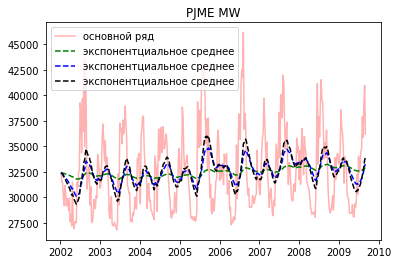

In [369]:
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

N100=400
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_w.index[:N100],data_w['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [372]:
data_w.iloc[:4,8]=0

Добавим истории длиной p в признаках автокорреляции

In [373]:
p = 4
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

Аналогично добавляем первые разности на глубину p

In [374]:
p = 4
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

In [375]:
data_w.head(10)

,PJME_MW,month,quarter,weekofyear,haveHoliday,week_month,pca1,pca2,diff1,diff1_w,...,exp_0_07,exp_0_08,t4,t3,t2,t1,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,1.0,0,-2.677833,-0.237572,0.000000,0.000000,...,32392.160839,32392.160839,0,0,0,0,0,0,0,0
2002-01-13,31487.386905,1.000000,1.0,2.0,0.0,0,-2.639384,-0.199889,0.000000,-0.028734,...,32328.826664,32319.778924,0,0,0,0,0,0,0,0
2002-01-20,31452.880952,1.000000,1.0,3.0,0.0,0,-2.600934,-0.162207,0.000000,-0.001097,...,32267.510464,32250.427087,0,0,0,0,0,0,0,0
2002-01-27,30141.529762,1.000000,1.0,4.0,1.0,0,-2.562485,-0.124524,0.000000,-0.043506,...,32118.691815,32081.715301,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,1.428571,1.0,5.0,0.0,0,-2.450482,-0.058573,-945.041687,-0.032368,...,31914.137554,31850.897124,32392,31487,31452,30141,0,0,0,0
2002-02-10,31150.517857,2.000000,1.0,6.0,0.0,0,-2.313962,0.016802,1954.029785,0.062729,...,31860.684176,31794.866783,31487,31452,30141,29196,0,0,0,-945
2002-02-17,30616.565476,2.000000,1.0,7.0,0.0,0,-2.275512,0.054484,-533.952393,-0.017440,...,31773.595867,31700.602678,31452,30141,29196,31150,0,0,-945,1954
2002-02-24,29144.130952,2.000000,1.0,8.0,1.0,0,-2.237063,0.092167,-1472.434570,-0.050523,...,31589.533323,31496.084940,30141,29196,31150,30616,0,-945,1954,-533
2002-03-03,29869.011905,2.428571,1.0,9.0,0.0,0,-2.125060,0.158118,724.880981,0.024269,...,31469.096823,31365.919097,29196,31150,30616,29144,-945,1954,-533,-1472


## Выделение существенных признаков

### Для h=1 и =4

In [398]:
h1=1
h4=4
scl_x=StandardScaler() 
X1 = data_w.iloc[p:-h1,:].values
X1 = scl_x.fit_transform(X1.astype('float64'))
X1.shape

(861, 27)

In [399]:
scl_x4=StandardScaler() 
X4 = data_w.iloc[p:-h4,:].values
X4 = scl_x4.fit_transform(X4.astype('float64'))
X4.shape

(858, 27)

In [400]:
scl_target1=StandardScaler() 
target_1 = data_w['PJME_MW'].values[h1+p:].reshape((data_w.shape[0]-h1-p,1))
y1 = scl_target1.fit_transform(target_1)
y1.shape

(861, 1)

In [401]:
scl_target4=StandardScaler() 
target_4 = data_w['PJME_MW'].values[h4+p:].reshape((data_w.shape[0]-h4-p,1))
y4 = scl_target4.fit_transform(target_4)
y4.shape

(858, 1)

In [402]:
X1[:8,11] = 0
X4[:8,11] = 0

In [403]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression

In [404]:
f_test1, _ = f_regression(X1, y1.ravel())
f_test1 /= np.max(f_test1)
for i in range(X1.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test1[i],i))

F-test=0.97,  I=0
F-test=0.00,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.00,  I=5
F-test=0.00,  I=6
F-test=0.00,  I=7
F-test=0.02,  I=8
F-test=0.01,  I=9
F-test=1.00,  I=10
F-test=0.00,  I=11
F-test=0.02,  I=12
F-test=0.01,  I=13
F-test=0.01,  I=14
F-test=0.02,  I=15
F-test=0.03,  I=16
F-test=0.04,  I=17
F-test=0.05,  I=18
F-test=0.07,  I=19
F-test=0.16,  I=20
F-test=0.30,  I=21
F-test=0.51,  I=22
F-test=0.04,  I=23
F-test=0.03,  I=24
F-test=0.02,  I=25
F-test=0.02,  I=26


In [405]:
f_test4, _1 = f_regression(X4, y4.ravel())
f_test4 /= np.max(f_test4)
for i in range(X4.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test4[i],i))

F-test=0.98,  I=0
F-test=0.02,  I=1
F-test=0.03,  I=2
F-test=0.02,  I=3
F-test=0.07,  I=4
F-test=0.02,  I=5
F-test=0.02,  I=6
F-test=0.00,  I=7
F-test=0.18,  I=8
F-test=0.18,  I=9
F-test=1.00,  I=10
F-test=0.63,  I=11
F-test=0.13,  I=12
F-test=0.01,  I=13
F-test=0.08,  I=14
F-test=0.11,  I=15
F-test=0.13,  I=16
F-test=0.12,  I=17
F-test=0.11,  I=18
F-test=0.09,  I=19
F-test=0.00,  I=20
F-test=0.10,  I=21
F-test=0.42,  I=22
F-test=0.19,  I=23
F-test=0.23,  I=24
F-test=0.25,  I=25
F-test=0.22,  I=26


In [406]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X1, y1.ravel())
X_new1.shape

(861, 5)

In [410]:
sfk4 =SelectKBest(f_regression, k=5)
X_new4 =sfk4.fit_transform(X4, y4.ravel())
X_new4.shape

(858, 5)

In [411]:
column_names = data_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 'd_m13', 't1', 'd2'], dtype='object')

In [412]:
column_names4 = data_w.columns[sfk4.get_support()]
column_names4

Index(['PJME_MW', 'diff1_l', 'd_m13', 't1', 'd2'], dtype='object')

In [413]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X1, y1.ravel())
X_new2.shape

(861, 3)

In [414]:
sfp4=SelectPercentile(f_regression, percentile=10)
X_new42 = sfp4.fit_transform(X4, y4.ravel())
X_new42.shape

(858, 3)

In [415]:
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 't1'], dtype='object')

In [416]:
column_namesp = data_w.columns[sfp4.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 'd_m13'], dtype='object')

In [418]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X1, y1.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X1, y1.ravel())
X_new3 = sfm.transform(X1)
X_new3.shape

(861, 4)

In [419]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X4, y4.ravel())
sfm4 = SelectFromModel(gr_model,  max_features = 5)

sfm4.fit(X4, y4.ravel())
X_new43 = sfm4.transform(X4)
X_new43.shape

(858, 5)

In [420]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

In [421]:
list_param_k4 =np.where(sfk4.get_support())[0]
list_param_p4 =np.where(sfp4.get_support())[0]
list_param_m4 =np.where(sfm4.get_support())[0]

In [422]:
print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 10 11 22 25]
Номера признаков лучших признаков по процентной форме:  [ 0 10 22]
Номера признаков для выбора по модели :  [ 0  7 10 11]


In [424]:
list_par=[0,7,10,11,22,25]
X_new = X1[:,list_par]
data_w.columns[list_par]

Index(['PJME_MW', 'pca2', 'diff1_l', 'd_m13', 't1', 'd2'], dtype='object')

In [425]:
print('Номера признаков k лучших признаков : ',list_param_k4)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p4)
print('Номера признаков для выбора по модели : ',list_param_m4)

Номера признаков k лучших признаков :  [ 0 10 11 22 25]
Номера признаков лучших признаков по процентной форме:  [ 0 10 11]
Номера признаков для выбора по модели :  [ 0  1  7 10 11]


In [426]:
list_par4=[0,1,7,10,11,22,25]
X_new4 = X4[:,list_par]
data_w.columns[list_par]

Index(['PJME_MW', 'pca2', 'diff1_l', 'd_m13', 't1', 'd2'], dtype='object')

## Разделение данных на тестовые и тренировочные 

In [319]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

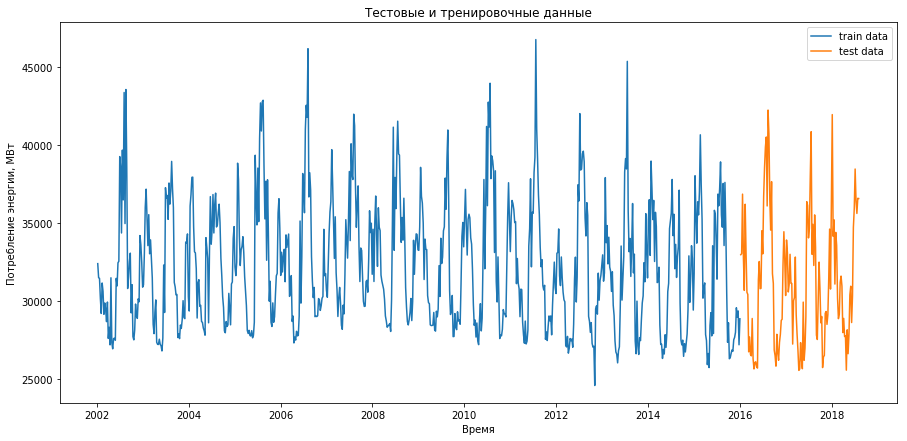

In [427]:
train, test = split_data( data_w, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [428]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [429]:
X_train4 =X_new4[:train.shape[0],:]
y_train4 =y4[:train.shape[0],0]
X_test4 =X_new4[train.shape[0]:,:]
y_test4 =y4[train.shape[0]:,0]

In [430]:
train.shape

(731, 27)

# Строим Модель

In [323]:
from sklearn.ensemble import GradientBoostingRegressor

In [431]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [432]:
model_g.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

**Посмотрим тесты**

In [433]:
X_test.shape

(130, 6)

In [434]:
y_test_pred_g = model_g.predict(X_test)

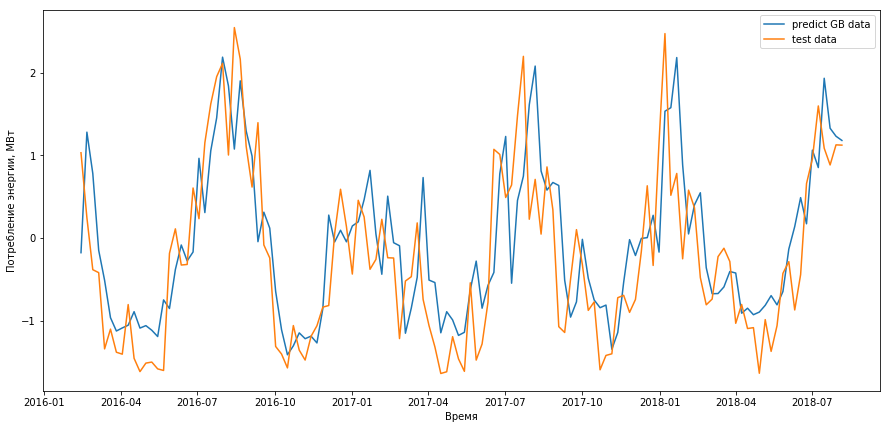

In [435]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h1+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h1+p:],y_test, label='test data')

plt.legend()
plt.show()

**Оценки для сравнения моделей**

In [436]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [437]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.4803034192447557 
ошибка mae  :   0.5628584599060068 
оценка R2 :   0.5476220243103536


In [438]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [439]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.187821139107409 %


In [440]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.671 (std: 0.043)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.660 (std: 0.043)
Parameters: {'n_estimators': 200, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.619 (std: 0.044)
Parameters: {'n_estimators': 300, 'max_depth': 4}



In [441]:
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=100)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.052277828709571 %


## Сохраниение модели

In [442]:
import pickle
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))

In [443]:
scl_x.scale_[0] , scl_x.mean_[0]

(3988.022510057557, 32080.034119151045)

### Для h=4

**Оценки для сравнения моделей**

In [445]:
param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train4, y_train4)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.519 (std: 0.053)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.512 (std: 0.059)
Parameters: {'n_estimators': 200, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.509 (std: 0.048)
Parameters: {'n_estimators': 300, 'max_depth': 1}



In [446]:
model_g_best4 = GradientBoostingRegressor(max_depth=2,  n_estimators=100)
model_g_best4.fit( X_train4, y_train4 ) 
y_test_pred_g4 = model_g_best4.predict(X_test4)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test4),y_pred = scl_target.inverse_transform( y_test_pred_g4))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   9.336967920642993 %


## Сохраниение модели

In [447]:
import pickle
# save the model to disk
filename = 'final_model4.sav'
pickle.dump(model_g_best4, open(filename, 'wb'))

filename = 'final_scaler_y4.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x4.sav'
pickle.dump(scl_x, open(filename, 'wb'))

In [448]:
scl_x.scale_[0] , scl_x.mean_[0]

(3988.022510057557, 32080.034119151045)

## Использование модели для предсказания n*h моментов времени

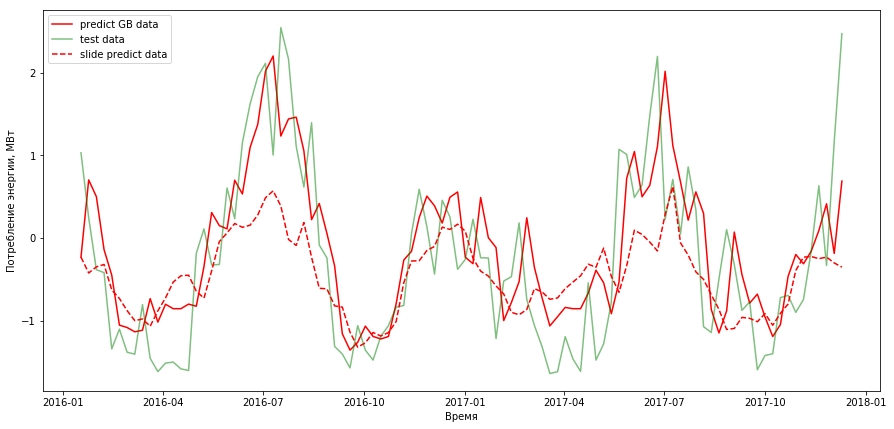

In [467]:
# Index(['PJME_MW', 'pca2', 'diff1_l', 'd_m13', 't1', 'd2'], dtype='object')
X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()
N10 = 100
for i in range(N10):
    y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,6)))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0] 
    
    #строим 'diff1_l' - признак под номером 2
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[15])*scl_x.scale_[15]
    #устанавливаем новое значение для 2
    X_test_100[i+1,2] = xy_i        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()

In [468]:
N = [10,20,30,40,50,60,70,80,90,100]
K=0
for N10 in N:
    er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[K:N10]),y_pred = scl_target.inverse_transform( y_test_100[K:N10]))
    K+=10
    print ("N10 = ", N10)
    print('ошибка градиентного бустинга MAPE :  ', er_g,'%')


N10 =  10
ошибка градиентного бустинга MAPE :   6.165920656921889 %
N10 =  20
ошибка градиентного бустинга MAPE :   10.051617250215141 %
N10 =  30
ошибка градиентного бустинга MAPE :   12.435335252128562 %
N10 =  40
ошибка градиентного бустинга MAPE :   6.133530416862437 %
N10 =  50
ошибка градиентного бустинга MAPE :   4.222408074236237 %
N10 =  60
ошибка градиентного бустинга MAPE :   5.363409501371519 %
N10 =  70
ошибка градиентного бустинга MAPE :   11.992116600296159 %
N10 =  80
ошибка градиентного бустинга MAPE :   9.929959545626103 %
N10 =  90
ошибка градиентного бустинга MAPE :   7.401564079280343 %
N10 =  100
ошибка градиентного бустинга MAPE :   7.836755869467435 %


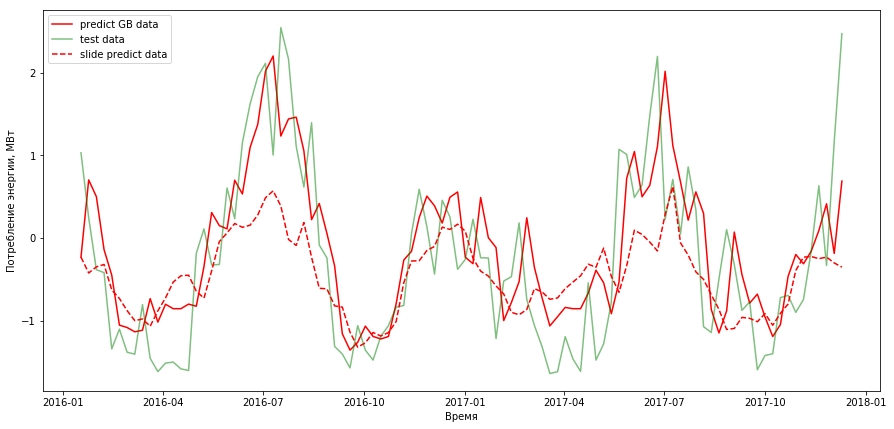

In [476]:
# Index(['PJME_MW', 'pca2', 'diff1_l', 'd_m13', 't1', 'd2'], dtype='object')
X_test4_100 = X_test4.copy()
y_test4_100 = y_test_pred_g.copy()
N10 = 100
for i in range(N10):
    y_test4_100[i] = model_g_best4.predict(X_test4_100[i,:].reshape((1,6)))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test4_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test4_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    #строим 'diff1_l' - признак под номером 4
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[15])*scl_x.scale_[15]
    #устанавливаем новое значение для 4
    X_test4_100[i+1,4] = xy_i        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()

In [470]:
N = [10,20,30,40,50,60,70,80,90,100]
K = 0
for N10 in N:
    er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[K:N10]),y_pred = scl_target.inverse_transform( y_test_100[K:N10]))
    K+=10
    print ("N10 = ", N10)
    print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

N10 =  10
ошибка градиентного бустинга MAPE :   6.165920656921889 %
N10 =  20
ошибка градиентного бустинга MAPE :   10.051617250215141 %
N10 =  30
ошибка градиентного бустинга MAPE :   12.435335252128562 %
N10 =  40
ошибка градиентного бустинга MAPE :   6.133530416862437 %
N10 =  50
ошибка градиентного бустинга MAPE :   4.222408074236237 %
N10 =  60
ошибка градиентного бустинга MAPE :   5.363409501371519 %
N10 =  70
ошибка градиентного бустинга MAPE :   11.992116600296159 %
N10 =  80
ошибка градиентного бустинга MAPE :   9.929959545626103 %
N10 =  90
ошибка градиентного бустинга MAPE :   7.401564079280343 %
N10 =  100
ошибка градиентного бустинга MAPE :   7.836755869467435 %
